In [1]:
## This Python 3 environment comes with many helpful analytics libraries installed
## It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
## For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

## Input data files are available in the read-only "../input/" directory
## For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

## You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
## You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

11/04/20 - Public score 0.74, highest score 0.791

In [2]:
import sys
!cp ../input/rapids/rapids.0.16.0 /opt/conda/envs/rapids.tar.gz
!cd /opt/conda/envs/ && tar -xzvf rapids.tar.gz > /dev/null
sys.path = ["/opt/conda/envs/rapids/lib/python3.7/site-packages"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib/python3.7"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib"] + sys.path 
!cp /opt/conda/envs/rapids/lib/libxgboost.so /opt/conda/lib/

In [3]:
import gc
import pandas as pd
import numpy as np

In [4]:
# Rapids Imports
import cudf
import cupy # CuPy is an open-source array library accelerated with NVIDIA CUDA.


#from dask.distributed import Client, wait
#from dask_cuda import LocalCUDACluster

#cluster = LocalCUDACluster()
#client = Client(cluster)
#client

In [5]:
%%time

# Read in data
dtypes = {
    "row_id": "int64",
    "timestamp": "int64",
    "user_id": "int32",
    "content_id": "int16",
    "content_type_id": "boolean",
    "task_container_id": "int16",
    "user_answer": "int8",
    "answered_correctly": "int8",
    "prior_question_elapsed_time": "float32", 
    "prior_question_had_explanation": "int8"
}

train = cudf.read_csv('../input/riiid-test-answer-prediction/train.csv', dtype=dtypes)

# Let's exclude all observations where (content_type_id = 1) & (answered_correctly = -1)
train = train[train['content_type_id'] != 1]
train = train[train['answered_correctly'] != -1].reset_index(drop=True)

CPU times: user 6.57 s, sys: 3.45 s, total: 10 s
Wall time: 23.9 s


In [6]:
# Find Missing Data if any
total = len(train)

for column in train.columns:
    if train[column].isna().sum() != 0:
        print("{} has: {:,} ({:.2}%) missing values.".format(column, train[column].isna().sum(), 
                                                             (train[column].isna().sum()/total)*100))
        
        
# Fill in missing values with "-1"
train["prior_question_elapsed_time"] = train["prior_question_elapsed_time"].fillna(train["prior_question_elapsed_time"].mean().astype("float32"))
train["prior_question_had_explanation"] = train["prior_question_had_explanation"].fillna(0)

#train.head()

prior_question_elapsed_time has: 392,506 (0.4%) missing values.
prior_question_had_explanation has: 392,506 (0.4%) missing values.


In [7]:
# Parameters
train_percent = 0.1

# Split data into train data & feature engineering data (to use for past performance)
# Timestamp is in descending order - meaning that the last 10% observations have
# the biggest chance of having had some performance recorded before
# so looking at the performance in the past we'll try to predict the performance now

features_df = train.iloc[:int((1-train_percent) * len(train))]
train_df = train.iloc[:int((train_percent) * len(train))]

del train
gc.collect()

0

In [8]:
%%time
# --- STUDENT ANSWERS ---
# Group by student
user_answers = features_df[features_df['answered_correctly']!=-1].\
                            groupby('user_id').\
                            agg({'answered_correctly': ['sum', 'mean', 'min', 
                                                        'max', 'count', 'median', 
                                                        'std', 'var']}).\
                            reset_index()

user_answers.columns = ['user_id', 'user_sum', 'user_mean', 'user_min', 'user_max', 
                        'user_count', 'user_median', 'user_std', 'user_var']


# --- CONTENT ID ANSWERS ---
# Group by content
content_answers = features_df[features_df['answered_correctly']!=-1].\
                            groupby('content_id').\
                            agg({'answered_correctly': ['sum', 'mean', 'min', 
                                                        'max', 'count', 'median', 
                                                        'std', 'var']}).\
                            reset_index()

content_answers.columns = ['content_id', 'content_sum', 'content_mean', 'content_min', 
                           'content_max', 'content_count', 'content_median', 'content_std', 
                           'content_var']

CPU times: user 2.23 s, sys: 322 ms, total: 2.55 s
Wall time: 2.59 s


In [9]:
questions = cudf.read_csv('../input/riiid-test-answer-prediction/questions.csv')

#questions
#questions.shape

## Find Missing Data if any
#total = len(questions)
#for column in questions.columns:
#    if questions[column].isna().sum() != 0:
#        print("{} has: {:,} ({:.2}%) missing values.".format(column, questions[column].isna().sum(), 
#                                                             (questions[column].isna().sum()/total)*100))
## tags has: 1 (0.0074%) missing values.

question_part = questions[['question_id', 'part', 'tags']]
#question_part.head()

features_df = features_df.merge(question_part, how = 'left', left_on = 'content_id', right_on = 'question_id')
features_df.head()

del questions
gc.collect()

26

In [10]:
part_qs = features_df.groupby('part').agg({'answered_correctly': ['sum','count']}).reset_index()
part_qs.columns = ['part', 'part_answers_sum', 'part_answers_count']
part_qs['part_correct_percentage'] = part_qs['part_answers_sum'] / part_qs['part_answers_count']
part_qs

del features_df
gc.collect()

20

In [11]:
# Features for ML
features_to_keep = ['user_mean', 'user_count', 'user_std', 'content_sum', 'content_mean',
                    'content_std','part','part_correct_percentage']
target = 'answered_correctly'
all_features = features_to_keep.copy()
all_features.append(target)


# We need to convert True-False variables to integers
def to_bool(x):
    '''For the string variables.'''
    if x == False:
        return 0
    else:
        return 1

    
def combine_features(data = None):
    '''Combine the features with the Train/Test data.'''
    
    ## Add "past" information
    features_data = data.merge(user_answers, how = 'left', on = 'user_id')
    features_data = features_data.merge(content_answers, how = 'left', on = 'content_id')
    features_data = features_data.merge(question_part, how = 'left', left_on = 'content_id', right_on = 'question_id')
    features_data = features_data.merge(part_qs[['part','part_correct_percentage']], how = 'left', on = 'part')

    ## Apply
    features_data['content_type_id'] = features_data['content_type_id'].applymap(to_bool)
    features_data['prior_question_had_explanation'] = features_data['prior_question_had_explanation'].applymap(to_bool)

    ## Fill in missing spots
    #features_data['user_mean'].fillna(value = user_answers['user_mean'].mean(), inplace = True)
    #features_data['user_count'].fillna(value = int(user_answers['user_count'].mean()), inplace = True)
    #features_data['user_std'].fillna(value = user_answers['user_std'].mean(), inplace = True)
    
    user_count_mean = 252
    user_mean_mean = 0.545
    user_std_mean = 0.475
    
    features_data['user_mean'].fillna(value = user_mean_mean, inplace = True)
    features_data['user_count'].fillna(value = user_count_mean, inplace = True)
    features_data['user_std'].fillna(value = user_std_mean, inplace = True)
    features_data.fillna(value = -1, inplace = True)
    
    return features_data

In [12]:
user_answers.mean()

user_id        9.692184e+08
user_sum       1.657566e+02
user_mean      5.451151e-01
user_min       5.419014e-04
user_max       9.995315e-01
user_count     2.521653e+02
user_median    6.438099e-01
user_std       4.752492e-01
user_var       2.274764e-01
dtype: float64

In [13]:
#train_df = train_df.merge(question_part, how = 'left', left_on = 'content_id', right_on = 'question_id')
#train_df.head()

In [14]:
%%time

train_df = combine_features(data=train_df)

# Comment this if you're scaling
train_df = train_df[all_features]

print("Observations in train: {:,}".format(len(train_df)))
train_df.head()

Observations in train: 9,927,130
CPU times: user 5.75 s, sys: 490 ms, total: 6.24 s
Wall time: 6.52 s


,user_mean,user_count,user_std,content_sum,content_mean,content_std,part,part_correct_percentage,answered_correctly
0,0.691832,2265,0.461838,19067,0.644635,0.478632,6,0.669344,1
1,0.691832,2265,0.461838,3865,0.479350,0.499604,6,0.669344,1
2,0.691832,2265,0.461838,10426,0.352277,0.477688,6,0.669344,1
3,0.691832,2265,0.461838,11384,0.653314,0.475928,6,0.669344,0
4,0.691832,2265,0.461838,10426,0.352277,0.477688,6,0.669344,0


In [15]:
train_df_pd = train_df.to_pandas()

In [16]:
from fastai.tabular.all import *

cont_nn = ['user_mean','user_count', 'user_std','content_sum','content_mean',
           'content_std','part_correct_percentage']
cat_nn = ['part']
features = cont_nn + cat_nn

procs_nn = [Categorify, FillMissing, Normalize]
valid_range = list(range(len(train_df_pd) - int(len(train_df_pd) / 10), len(train_df_pd)))
batch_size = 1042
dls = TabularDataLoaders.from_df(train_df_pd, procs=procs_nn, cat_names=cat_nn, cont_names=cont_nn,
                                 y_names='answered_correctly', valid_idx=valid_range, bs=1042)

#dls.show_batch()

In [17]:
from sklearn.metrics import roc_auc_score

def my_auc(inp, targ):
    "Simple wrapper around scikit's roc_auc_score function for regression problems"
    inp,targ = flatten_check(inp,targ)
    return roc_auc_score(targ.cpu().numpy(), inp.cpu().numpy())

learn = tabular_learner(dls, layers=[200,100], metrics=my_auc)

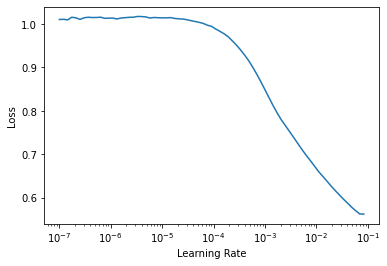

In [18]:
lr_find_res = learn.lr_find()

In [19]:
%%time
learn.fit_one_cycle(5, lr=lr_find_res.lr_min)

epoch,train_loss,valid_loss,my_auc,time
0,0.185744,0.182801,0.753481,02:20
1,0.183255,0.182131,0.754912,02:24
2,0.184160,0.181958,0.755265,02:22
3,0.183321,0.181869,0.755475,02:18
4,0.183743,0.181818,0.755617,02:18


CPU times: user 11min 35s, sys: 7.57 s, total: 11min 42s
Wall time: 11min 44s


In [20]:
def predict_batch(self, df):
    dl = self.dls.test_dl(df)
    dl.dataset.conts = dl.dataset.conts.astype(np.float32)
    inp,preds,_,dec_preds = self.get_preds(dl=dl, with_input=True, with_decoded=True)
    return preds.numpy()

setattr(learn, 'predict_batch', predict_batch)

In [21]:
#%%time

#target = ['answered_correctly']

#setattr(learn, 'predict_batch', predict_batch)

#sample_size = 2000000
#preds = learn.predict_batch(learn, train_df_pd[features].iloc[:sample_size])
#y_pred_sample = train_df_pd[target][:sample_size].values
#roc_auc_score(y_pred_sample, preds)

In [22]:
#%%time
## Check with example_test
#example_test = cudf.read_csv('/kaggle/input/riiid-test-answer-prediction/example_test.csv')
#example_test = combine_features(data=example_test)
#example_test = example_test.to_pandas()
    
#y_preds = learn.predict_batch(learn, example_test[features])
#example_test['answered_correctly'] = y_preds

In [23]:
import riiideducation

env = riiideducation.make_env()

In [24]:
%%time
iter_test = env.iter_test()

#submission = pd.DataFrame(columns=["row_id", "answered_correctly"])

for (test_df, sample_prediction_df) in iter_test:
    
    test_df = cudf.from_pandas(test_df)
    test_df = combine_features(data=test_df)
    test_df = test_df.to_pandas()
    
    y_preds = learn.predict_batch(learn, test_df[features])
    test_df['answered_correctly'] = y_preds
    env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])

    #submission = submission.append(test_df[['row_id', 'answered_correctly']], ignore_index=True)
    
#submission.to_csv('submission.csv')

CPU times: user 550 ms, sys: 25.7 ms, total: 575 ms
Wall time: 785 ms
